# Segmentation

The purpose of segmentation is to separate the background from the objects of interest. Segmentation becomes significantly harder when objects are overlapped.

In [1]:
from scipy import misc
import numpy as np
from matplotlib import pyplot as plt
from functools import partial

image_path = 'key1.jpg'

image_color = misc.imread(image_path)
image_data = misc.imread(image_path, mode='L')

We can display an image with the *plt.imshow* function.

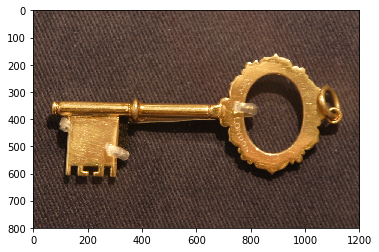

In [2]:
plt.imshow(image_color)

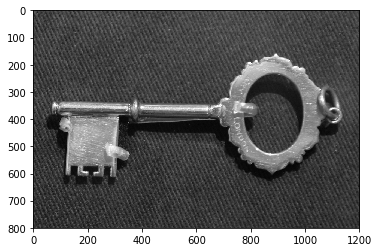

In [3]:
plt.imshow(image_data, cmap='gray')

In [4]:
image_data.shape # Determine dimensions of the image

(800, 1200)

## Automatic threshold

In these methods we come up with a value, a threshold, and all the values above the threshold will belong to the object interest, the values below the threshold will belong to the background.

### Method based on the mode

In [5]:
hist, bin_edges = np.histogram(image_data)

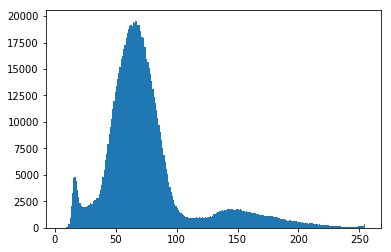

In [6]:
anything = plt.hist(image_data.ravel(), bins=250) # ravel() returns the array but flattened

In the mode method for threshold segmentation we look at a histogram of the pixel values. We notice that there seem to be two modes or peaks. The threshold should be set at the point where the two "bell curves" intersect. In the histogram we can see that this point is around 120.

We will now create a function `apply_threshold` that will take a single value (this will be the grayscale intensity of a pixel) and a threshold, and if that value is greater than the threshold it will make the pixel value equal to the highest possible.

This function is "vectorized" through `np.vectorize`
 which makes it capable of taking an ndarray as an argument and apply its logic to each element of the ndarray, creating a new ndarray whose elements are the return values of the function for each element. We also use the `partial` method from functools to inject the threshold value.

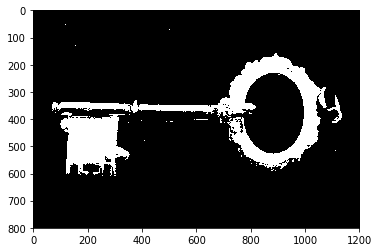

In [7]:
def binarize_image(value, threshold):
    if value > threshold:
        return 255
    return 0

segment_binary = np.vectorize(partial(binarize_image, threshold=120))
mode_image_data = segment_binary(image_data)

plt.imshow(mode_image_data, cmap='gray')

Let's see what happens when we use different treshold values:

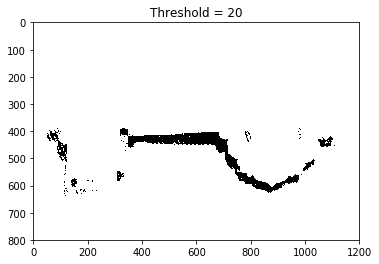

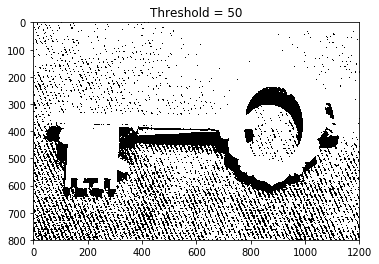

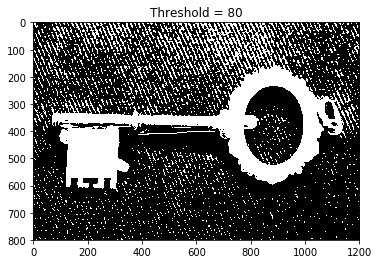

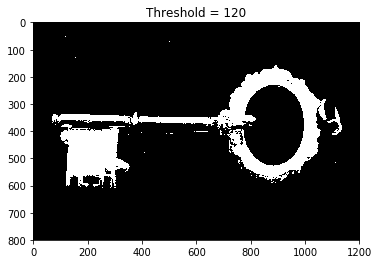

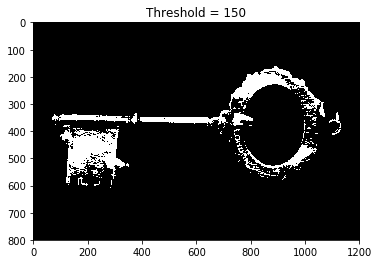

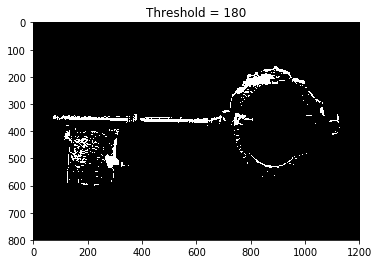

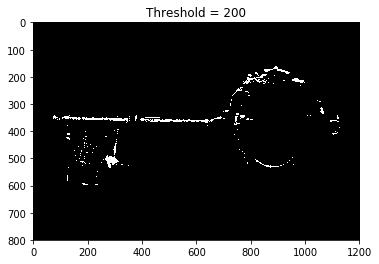

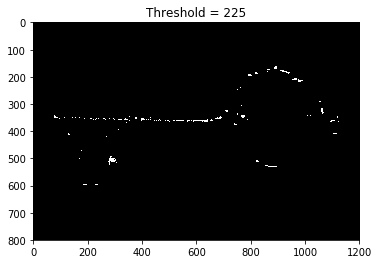

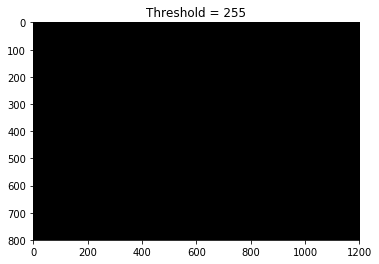

In [8]:
for threshold in [20, 50, 80, 120, 150, 180, 200, 225, 255]:
    apply_mode_method = np.vectorize(partial(binarize_image, threshold=threshold))
    plt.figure()
    plt.title('Threshold = {}'.format(threshold))
    plt.imshow(apply_mode_method(image_data), cmap='gray')

### Iterative method

1. Select an initial threshold. The average is a good candiate.
2. Segment the image in two sections based on the threshold.
3. Calculate the mean values of each of the segmented regions.
4. Improve the threshold to be the average of the two new thresholds.
5. Repeat steps two to four untill convergence.

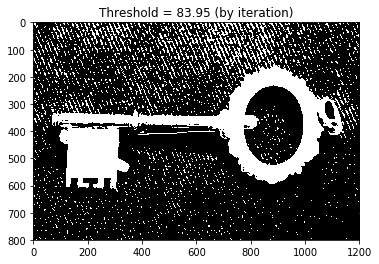

In [9]:
average_intensity = np.mean(image_data.ravel())

def calculate_region_means(image_data, threshold):
    region_one = []
    region_two = []
    rows, cols = image_data.shape
    for i in range(rows):
        for j in range(cols):
            value = image_data[i,j]
            if value > threshold:
                region_one.append(value)
            else:
                region_two.append(value)
    return np.mean(region_one), np.mean(region_two)

def iterative_method(image_data, delta=1):
    delta1 = 255;
    delta2 = 255;
    region_1_mean, region_2_mean = calculate_region_means(image_data, average_intensity)
    threshold = (region_1_mean + region_2_mean) / 2
    
    while (delta1 > delta or delta2 > delta):
        region_1_mean_new, region_2_mean_new = calculate_region_means(image_data, threshold)
        delta1 = region_1_mean_new - region_1_mean
        delta2 = region_2_mean_new - region_2_mean
        region_1_mean = region_1_mean_new
        region_2_mean = region_2_mean_new
        
    return threshold

threshold = iterative_method(image_data)

segment_binary = np.vectorize(partial(binarize_image, threshold=threshold))

plt.figure()
plt.title('Threshold = {:4.2f} (by iteration)'.format(threshold))
plt.imshow(segment_binary(image_data), cmap='gray')